## *Практична робота №3.* Класифікація твітів за тональністю з використанням Word2Vec та scikit-learn моделей
 
## Завдання: побудувати класифікаційні моделі для прогнозування тональності твітів, використовуючи векторні представлення тексту (Word2Vec).  
## Додатково: дослідити вплив зниження розмірності ознак за допомогою PCA на точність класифікації.


# Підключення бібліотек

In [1]:
!pip install numpy pandas matplotlib scikit-learn gensim nltk tqdm

In [16]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
from gensim.models import Word2Vec, KeyedVectors

# Завантаження списку стоп-слів для англійської мови

In [21]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Підключення sklearn компонентів

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Завантаження та перевірка датасету
Завантажуємо CSV файли з твітами та перевіряємо структуру таблиці.

In [19]:
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test_df  = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)
print(train_df.head())

Train shape: (41157, 6)
Test shape:  (3798, 6)
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


# Функція попередньої обробки тексту
Очищаємо текст і перетворюємо його на список "чистих" слів.

In [22]:
def preprocess_text(text):
    text = str(text).lower()                       # Переводимо текст у нижній регістр
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Видаляємо URL
    text = re.sub(r'[^a-z\s]', '', text)          # Лишаємо тільки літери
    tokens = text.split()                          # Токенізація простим розбиттям
    tokens = [w for w in tokens if w not in stop_words]  # Видаляємо стоп-слова
    return tokens

# Застосування токенізації до колонок OriginalTweet
train_df['tokens'] = train_df['OriginalTweet'].apply(preprocess_text)
test_df['tokens']  = test_df['OriginalTweet'].apply(preprocess_text)

print("\nПеревірка токенізації:")
print(train_df[['OriginalTweet', 'tokens']].head())


Перевірка токенізації:
                                       OriginalTweet  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1  advice Talk to your neighbours family to excha...   
2  Coronavirus Australia: Woolworths to give elde...   
3  My food stock is not the only one which is emp...   
4  Me, ready to go at supermarket during the #COV...   

                                              tokens  
0                    [menyrbie, philgahan, chrisitv]  
1  [advice, talk, neighbours, family, exchange, p...  
2  [coronavirus, australia, woolworths, give, eld...  
3  [food, stock, one, empty, please, dont, panic,...  
4  [ready, go, supermarket, covid, outbreak, im, ...  


# Навчання Word2Vec моделі 
Створюємо векторні представлення слів для подальшої класифікації.

Далі для кожного твіту беремо середнє embedding-ів його слів → отримуємо векторне представлення документа.

Перетворюємо категорії Sentiment у числові значення.

In [23]:
vector_size = 100
w2v_model = Word2Vec(sentences=train_df['tokens'], vector_size=vector_size, window=5, min_count=2, workers=4, sg=1)

# Функція для формування вектора твіту
def tweet_vector(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count > 0:
        vec /= count
    return vec

# Створення матриці ознак для тренування та тесту
X_train = np.array([tweet_vector(t, w2v_model, vector_size) for t in train_df['tokens']])
X_test  = np.array([tweet_vector(t, w2v_model, vector_size) for t in test_df['tokens']])

# Підготовка цільової змінної
le = LabelEncoder()
y_train = le.fit_transform(train_df['Sentiment'])
y_test  = le.transform(test_df['Sentiment'])

# Словник моделей
Навчання моделей та оцінка без PCA - тренуємо 4 моделі та оцінюємо їхню продуктивність без зниження розмірності.

In [24]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Naive Bayes': GaussianNB()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-score': f1_score(y_test, y_pred, average='weighted')
    }

results_df = pd.DataFrame(results).T
print("\n--- Результати без PCA ---")
print(results_df)


--- Результати без PCA ---
                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.417062   0.449069  0.417062  0.414343
SVM                  0.434439   0.487764  0.434439  0.431919
Random Forest        0.398631   0.428611  0.398631  0.398520
Naive Bayes          0.323591   0.333323  0.323591  0.284715


# Експеримент з PCA
Виконуємо класифікацію після зниження розмірності на 50 та 100 компонент

In [25]:
pca_components = [50, 100]
pca_results = {}

for n in pca_components:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca  = pca.transform(X_test)
    
    for name, model in models.items():
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        pca_results[(name, n)] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1-score': f1_score(y_test, y_pred, average='weighted')
        }

pca_results_df = pd.DataFrame(pca_results).T
print("\n--- Результати з PCA ---")
print(pca_results_df)


--- Результати з PCA ---
                         Accuracy  Precision    Recall  F1-score
Logistic Regression 50   0.399684   0.433772  0.399684  0.394691
SVM                 50   0.435756   0.470551  0.435756  0.437100
Random Forest       50   0.388099   0.424120  0.388099  0.386791
Naive Bayes         50   0.353870   0.357056  0.353870  0.338603
Logistic Regression 100  0.419695   0.452862  0.419695  0.416519
SVM                 100  0.458662   0.490876  0.458662  0.461573
Random Forest       100  0.397841   0.443473  0.397841  0.395515
Naive Bayes         100  0.337019   0.338920  0.337019  0.313535


# Confusion Matrix для найкращої моделі без PCA

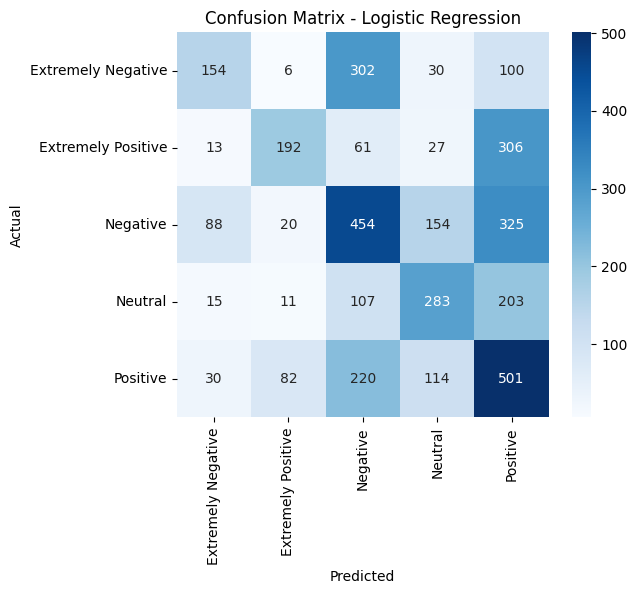

In [26]:
best_model = LogisticRegression(max_iter=500)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Візуалізація впливу PCA на Accuracy та F1-score

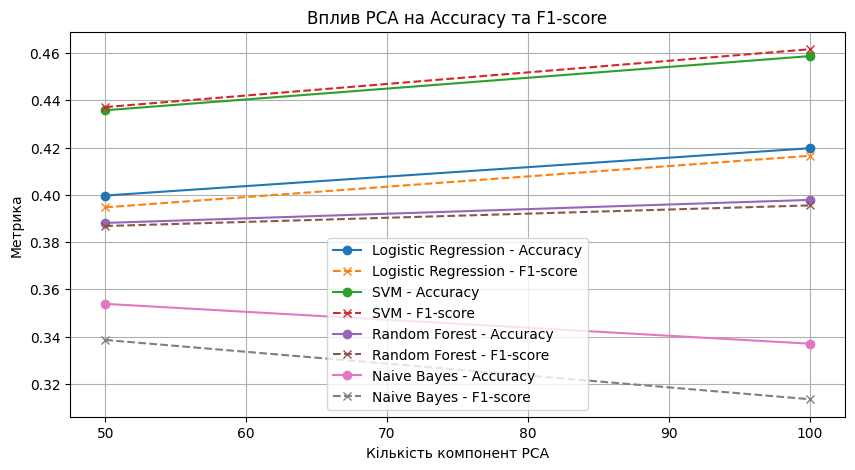

In [27]:
# Перетворимо pca_results_df для графіка
pca_plot_df = pca_results_df.reset_index()
pca_plot_df.rename(columns={'level_0':'Model', 'level_1':'PCA'}, inplace=True)
pca_plot_df['PCA'] = pca_plot_df['PCA'].astype(int)

# Графік Accuracy та F1-score залежно від кількості компонент PCA
plt.figure(figsize=(10,5))
for model in models.keys():
    subset = pca_plot_df[pca_plot_df['Model'] == model]
    plt.plot(subset['PCA'], subset['Accuracy'], marker='o', label=f'{model} - Accuracy')
    plt.plot(subset['PCA'], subset['F1-score'], marker='x', linestyle='--', label=f'{model} - F1-score')

plt.xlabel('Кількість компонент PCA')
plt.ylabel('Метрика')
plt.title('Вплив PCA на Accuracy та F1-score')
plt.legend()
plt.grid(True)
plt.show()

# Висновки

In [34]:
print("Висновки:")
# Найкраща модель
best_model_name = results_df['F1-score'].idxmax()
best_model_f1 = results_df.loc[best_model_name, 'F1-score']
print(f"- Найкраща модель без PCA: {best_model_name} (F1-score = {best_model_f1:.3f})")

# Вплив PCA
print("- Вплив PCA на моделі:")
for model in models.keys():
    acc_50 = pca_results_df.loc[(model,50),'Accuracy']
    acc_100 = pca_results_df.loc[(model,100),'Accuracy']
    f1_50 = pca_results_df.loc[(model,50),'F1-score']
    f1_100 = pca_results_df.loc[(model,100),'F1-score']
    print(f"  {model}: Accuracy 50→100 PCA: {acc_50:.3f} → {acc_100:.3f}, F1-score 50→100 PCA: {f1_50:.3f} → {f1_100:.3f}")

print("- Висновок: застосування PCA зменшує розмірність ознак, що може прискорити навчання, але інколи знижує точність. F1-score допомагає обрати найкращу модель.")

Висновки:
- Найкраща модель без PCA: SVM (F1-score = 0.432)
- Вплив PCA на моделі:
  Logistic Regression: Accuracy 50→100 PCA: 0.400 → 0.420, F1-score 50→100 PCA: 0.395 → 0.417
  SVM: Accuracy 50→100 PCA: 0.436 → 0.459, F1-score 50→100 PCA: 0.437 → 0.462
  Random Forest: Accuracy 50→100 PCA: 0.388 → 0.398, F1-score 50→100 PCA: 0.387 → 0.396
  Naive Bayes: Accuracy 50→100 PCA: 0.354 → 0.337, F1-score 50→100 PCA: 0.339 → 0.314
- Висновок: застосування PCA зменшує розмірність ознак, що може прискорити навчання, але інколи знижує точність. F1-score допомагає обрати найкращу модель.


# Прогноз нових твітів

In [29]:
def predict_new_tweet(text, w2v_model, vector_size, pca=None, model=None):
    # Очистка та токенізація
    tokens = preprocess_text(text)
    # Векторизація
    vec = tweet_vector(tokens, w2v_model, vector_size).reshape(1, -1)
    # PCA (якщо використовується)
    if pca is not None:
        vec = pca.transform(vec)
    # Прогноз
    pred = model.predict(vec)
    return le.inverse_transform(pred)[0]

# Приклад використання:
new_text = "I am very worried about the new COVID-19 variant"
predicted_sentiment = predict_new_tweet(new_text, w2v_model, vector_size, pca=None, model=best_model)
print(f"Новий твіт: '{new_text}' → Прогнозована тональність: {predicted_sentiment}")

Новий твіт: 'I am very worried about the new COVID-19 variant' → Прогнозована тональність: Negative
